In [178]:
import numpy as np
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, make_scorer
from sklearn.preprocessing import *
from sklearn.model_selection import *

import warnings
warnings.filterwarnings("ignore")

my_random_state = 2022

In [11]:
path = "/Users/sunshangwen/Dropbox (Personal)/Mac/Desktop/Git Uploads/MTH-9899-Data-Science-II-Project/merged_data.csv"
merged = pd.read_csv(path, sep = ",")

In [13]:
use_cols = ["Date", "Time", "Id", "ResidualNoWinsorCumReturn winsorized", "RawNoWinsorCumReturn winsorized",
           "estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized"]
merged = merged[use_cols]
merged.head(10)

,Date,Time,Id,ResidualNoWinsorCumReturn winsorized,RawNoWinsorCumReturn winsorized,estVol winsorized,SharesOutstanding winsorized,MDV_63 winsorized,CleanMid winsorized,CumVolume winsorized
0,20140102,10:00:00.000,IDZQ0003GF7,0.008795,0.008043,0.093123,110.580,4321539.0,32.009570,30851.0
1,20140102,10:00:00.000,IDZQ00047M8,-0.007513,-0.008949,0.129865,449.750,7728599.0,5.929723,100377.0
2,20140102,10:00:00.000,IDZQ00048R1,0.002052,0.001240,0.151308,227.481,34529812.0,46.881290,118814.0
3,20140102,10:00:00.000,IDZQ0005R34,-0.007269,-0.006079,0.122016,575.375,2318102.2,6.155510,57972.0
4,20140102,10:00:00.000,IDZQ0005SC2,-0.004682,-0.009140,0.066838,839.394,66501836.0,27.234093,399523.0
5,20140102,10:00:00.000,IDZQ0007ZC4,0.003457,0.002491,0.116665,257.146,15165916.0,12.642498,63488.0
6,20140102,10:00:00.000,IDZQ0008WW8,-0.004565,-0.006895,0.200375,1199.193,20980068.0,8.053623,792118.0
7,20140102,10:00:00.000,IDZQ0009HH7,0.001507,0.003108,0.150383,49.760,10001647.0,83.713650,57225.0
8,20140102,10:00:00.000,IDZQ0009P98,-0.008188,-0.005854,0.097242,120.265,13023300.0,52.391100,26265.0
9,20140102,10:00:00.000,IDZQ000BBR6,0.006872,0.001722,0.101256,1022.341,47041750.0,17.876140,458629.0


In [117]:
train = merged[merged["Date"] < 20170101]
#validation = merged[(merged["Date"] >= 20160101) & (merged["Date"] < 20170101)]
test = merged[merged["Date"] >= 20170101]

X_train = train[["estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized"]]
y_train = train["ResidualNoWinsorCumReturn winsorized"]
X_test = test[["estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized"]]
y_test = test["ResidualNoWinsorCumReturn winsorized"]

In [118]:
# scale the features in train set
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)

# do the same scaling to test set
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

In [187]:
def my_own_scorer(model, X, y):
    # note that feature estVol should always be set as the first column to 
    # make sure the expected weighted r2 score

    r2_weight = 1 / np.array(X.iloc[:, 0])
    r2_weight = r2_weight / r2_weight.sum()
    
    model.fit(X, y)
    y_pred = model.predict(X)
    
    return r2_score(y, y_pred, sample_weight = r2_weight)

In [188]:
def regmodel_hyperparameter_tuning(alphas_to_try, X, y, cv = 3, scoring = 'weighted r2', model_name = 'Ridge', 
                        X_test = None, y_test = None, draw_plot = False, filename = None):
    
    # tuning the hyper-parameter by grid searching
    # optimising on one basis but then comparing performance on another
    # scoring method: weighted R-squared
    validation_scores = []
    train_scores = []
    results_list = []
    
    tscv = TimeSeriesSplit(n_splits = cv)
 
    if X_test is not None:
        test_scores = []
        #scorer_test = get_scorer(my_own_scorer) ######################
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        
        if model_name == 'Lasso':
            regmodel = Lasso(alpha = curr_alpha)
            
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
            
        elif model_name == 'SimpleLR':
            regmodel = LinearRegression()
            
        else:
            return None
        
        results = cross_validate(regmodel, X, y, scoring = my_own_scorer, cv = tscv, return_train_score = True)
        print(results)
        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel.fit(X,y)
            y_pred = regmodel.predict(X_test)
            r2_weight = 1 / np.array(X_test.iloc[:, 0])
            r2_weight = r2_weight / r2_weight.sum()
            test_scores.append(r2_score(y_test, y_pred, sample_weight = r2_weight)) #######################
            

    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(validation_scores, train_scores, alphas_to_try, chosen_alpha, 
                            model_name, scoring, test_scores, filename)
        
    print("Chosen alpha: %.5f" % chosen_alpha)
    print("Validation score: %.5f" % max_validation_score)
    print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha



def regmodel_param_plot(validation_score, train_score, alphas_to_try, chosen_alpha, scoring,
                        model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, label = 'training_data')
    plt.axvline(x = chosen_alpha, linestyle = '--')
    
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, label = 'test_data')
        
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularization')
    plt.legend()
    
    if filename is not None:
        plt.savefig(str(filename) + ".png")
        
    plt.show()

{'fit_time': array([ 2.519171  ,  6.305161  , 11.76459599]), 'score_time': array([2.30992389, 2.50275087, 2.34262204]), 'test_score': array([-6.26036594, -0.44060089,  1.87763657]), 'train_score': array([-0.28055806, -0.31566954, -0.30123367])}
{'fit_time': array([0.05844688, 0.07759786, 0.085495  ]), 'score_time': array([0.02384305, 0.01803017, 0.01982284]), 'test_score': array([-6.09725347, -0.44188588,  1.96258958]), 'train_score': array([-0.27880782, -0.31264304, -0.29807136])}
{'fit_time': array([0.04379797, 0.07489204, 0.09765816]), 'score_time': array([0.01903391, 0.02135491, 0.02052093]), 'test_score': array([-6.09725347, -0.44188588,  1.96258958]), 'train_score': array([-0.27880782, -0.31264304, -0.29807136])}
{'fit_time': array([0.04414201, 0.06889677, 0.09695792]), 'score_time': array([0.01992989, 0.021065  , 0.02002501]), 'test_score': array([-6.09725347, -0.44188588,  1.96258958]), 'train_score': array([-0.27880782, -0.31264304, -0.29807136])}
{'fit_time': array([0.0421791

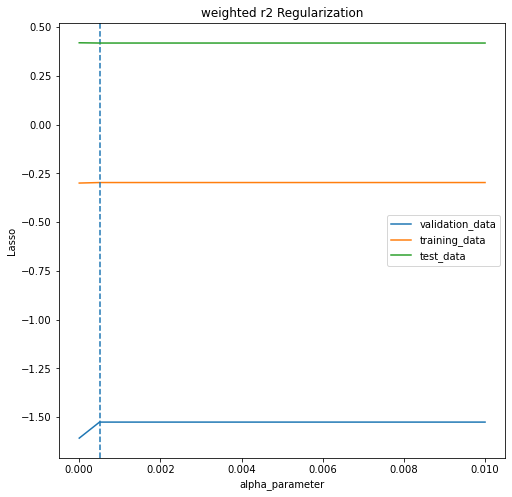

Chosen alpha: 0.00050
Validation score: -1.52552
Test score at chosen alpha: 0.41921


(0.0005, -1.5255165922872045, 0.4192057264940242)

In [189]:
# wide search
# lasso model
lasso_alphas = np.linspace(0, 0.01, 21)
tscv = TimeSeriesSplit(n_splits=3)
regmodel_hyperparameter_tuning(lasso_alphas, X_train_scaled, y_train, 
                               cv = 3, model_name = 'Lasso', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')